# Data exploration

We'll start by having a look at the data set. The ZooScanSet consists of 1,433,278 images of objects. Mostly classified as plankton, although significant parts of the data consist of *detritus*, *fiber detritus* or *badfocus__artefact* - as well as other less prominent categories that may not be called species. For the classifier, it will of course be necessary to recognize these so they're not mistaken for other species.

From the **ZooScan** manual, available at [https://sites.google.com/view/piqv/instruments-manuals], we know that all images are produced using an instrument much like a flatbed scanner. We assume,therefore, that sizes are comparable between images, and that any size variance in the data is due to actual size variance or possibly technical/labelling errors.

Images are all 8-bit single channel (gray scale) JPEG compressed images. This will need to be taken into consideration when using a pre-built architecture.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load data
taxa = pd.read_csv('../../data/ZooScanSet/taxa.csv', usecols=["objid","taxon"])

# we first have a look at the data.
taxa_distribution = taxa['taxon'].value_counts()

# look at the frequency distribution
print(taxa_distribution)

taxa['taxon'].value_counts().hist(bins=[0,250,500,1000,5000,10000,20000,50000,100000,250000,550000],
                                  figsize=(16,10))


detritus                           511700
Calanoida                          241495
badfocus__artefact                 100668
fiber__detritus                     68798
Oithonidae                          59317
Acartiidae                          46772
Chaetognatha                        36829
Calanidae                           26441
Evadne                              21359
Oikopleuridae                       20507
Phaeodaria                          17145
egg__other                          16443
Ostracoda                           14392
Coscinodiscus                       14040
multiple__other                     13617
Oncaeidae                           12766
bubble                              11669
Limacinidae                         11152
Corycaeidae                         11118
nauplii__Crustacea                   9334
cyphonaute                           9125
Temoridae                            9110
Salpida                              7772
Penilia                           


## A closer look at the frequency distribution

From the histogram above, we see that about 30 of 93 the data categories have less than 250 samples. If we include two more bins (< 1000 samples) we are at 51 of 93 bins. There are problems with this rather strong inbalance in the data:

* Model training will strongly emphasize the dominant classes
* For inference or testing, it is likely that we'll miss out on many of the rare classes, poor recall. This will be both due to lack of samples for evaluation (i.e. if you select 2% of 39 samples of Ctenophora it won't really tell you a lot) and a the imbalance in training.
* The model would also in a sence perform well (high accuracy) if it strongly prefers the dominant classes for classification, after all predicting "detritus" in any case would be correct in over 1/3 of the samples. We may be wary of many false positives for the dominant classes - a low precision.

### Handling the class imbalance
(Inspired by [https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6])

We have a few options:
* Cull the dominant categories down to the frequency of the less common ones
* Resample the less common categories to reuse the data
* Grow the less common categories by synthetisizing samples. This would be like a data augmentation, though selectively applied where it is perceived to be needed.

The first thing we can do, for starters, is to reduce the problem somewhat by only including the forty most abundant categories as suggested in the assignment. 


Index(['detritus', 'Calanoida', 'badfocus__artefact', 'fiber__detritus',
       'Oithonidae', 'Acartiidae', 'Chaetognatha', 'Calanidae', 'Evadne',
       'Oikopleuridae', 'Phaeodaria', 'egg__other', 'Ostracoda',
       'Coscinodiscus', 'multiple__other', 'Oncaeidae', 'bubble',
       'Limacinidae', 'Corycaeidae', 'nauplii__Crustacea', 'cyphonaute',
       'Temoridae', 'Salpida', 'Penilia', 'Noctiluca', 'zoea__Decapoda',
       'nauplii__Cirripedia', 'Foraminifera', 'nectophore__Diphyidae',
       'Brachyura', 'tail__Appendicularia', 'Centropagidae', 'Eucalanidae',
       'Haloptilus', 'Bivalvia__Mollusca', 'calyptopsis', 'Decapoda',
       'artefact', 'Doliolida', 'eudoxie__Diphyidae'],
      dtype='object')
detritus                 511700
Calanoida                241495
badfocus__artefact       100668
fiber__detritus           68798
Oithonidae                59317
Acartiidae                46772
Chaetognatha              36829
Calanidae                 26441
Evadne                    

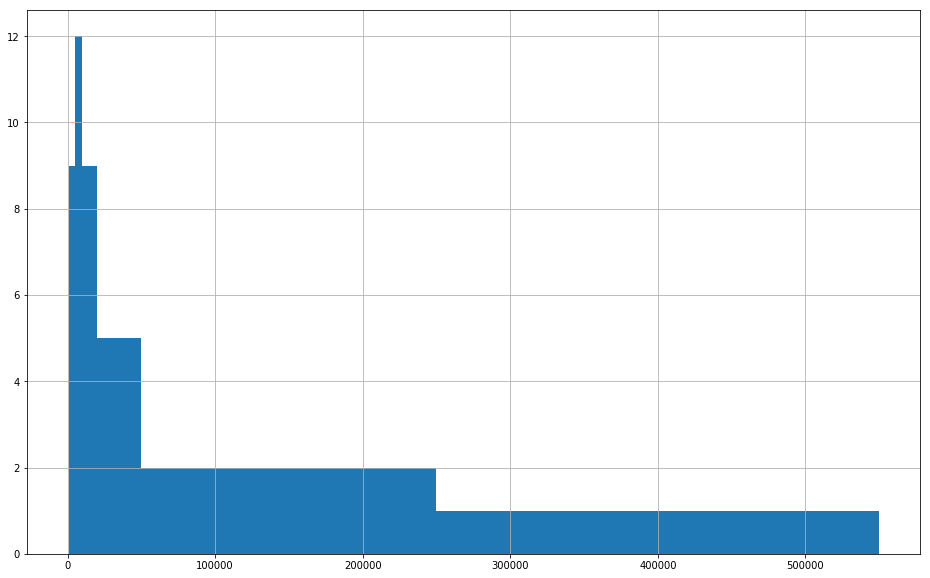

In [7]:
# only the most common categories please
top_taxa_labels = taxa_distribution[:40]
print(top_taxa_labels.index)

# reduce the data set to this
reduced = taxa.loc[taxa['taxon'].isin(top_taxa_labels.index)]

# have a look at the new distribution as above

print(reduced['taxon'].value_counts())

reduced['taxon'].value_counts().hist(bins=[0,250,500,1000,5000,10000,20000,50000,100000,250000,550000],
                                  figsize=(16,10))



For now, we will use the first option above. We will generate balanced test sets by stratification.

In [8]:
# downsample the data to a fully balanced set

downsampled = pd.DataFrame()
for label in top_taxa_labels.index:
    
    this_category = reduced.loc[reduced['taxon'] == label].sample(n=3455)
    downsampled = pd.concat([downsampled, this_category])
    print(label + ' - ' + str(np.shape(this_category)[0]))


detritus - 3455
Calanoida - 3455
badfocus__artefact - 3455
fiber__detritus - 3455
Oithonidae - 3455
Acartiidae - 3455
Chaetognatha - 3455
Calanidae - 3455
Evadne - 3455
Oikopleuridae - 3455
Phaeodaria - 3455
egg__other - 3455
Ostracoda - 3455
Coscinodiscus - 3455
multiple__other - 3455
Oncaeidae - 3455
bubble - 3455
Limacinidae - 3455
Corycaeidae - 3455
nauplii__Crustacea - 3455
cyphonaute - 3455
Temoridae - 3455
Salpida - 3455
Penilia - 3455
Noctiluca - 3455
zoea__Decapoda - 3455
nauplii__Cirripedia - 3455
Foraminifera - 3455
nectophore__Diphyidae - 3455
Brachyura - 3455
tail__Appendicularia - 3455
Centropagidae - 3455
Eucalanidae - 3455
Haloptilus - 3455
Bivalvia__Mollusca - 3455
calyptopsis - 3455
Decapoda - 3455
artefact - 3455
Doliolida - 3455
eudoxie__Diphyidae - 3455


In [31]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
lb = preprocessing.LabelBinarizer()

X = np.array(downsampled['objid'])
#y = pd.get_dummies(reduced['taxon'], sparse=False).values

le.fit(np.unique(downsampled['taxon']))

y = le.transform(downsampled['taxon'])
y = lb.fit_transform(y)

# split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.6, random_state=42, stratify=y)
print(np.shape(y))
print(np.shape(X))

/home/havard/anaconda3/envs/inf368/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(138200, 40)
(138200,)


In [44]:
import numpy as np
import keras
from PIL import Image
import cv2


class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=93, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def load_image(self, infilename ) :
        img = Image.open( infilename )
        img.load()
        #not good resizing, prbly
        img = img.resize((224,224), Image.BICUBIC)        
        data = np.asarray( img, dtype="int32").reshape(224,224,1)
        return data
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            print (i, ID)
            print(self.labels[i])
            X[i,] = self.load_image('../../data/ZooScanSet/imgs/'+ str(ID[1]) + '/' + str(ID[0]) + '.jpg')

            # Store class
            y[i] = self.labels[i]

        return X, y

In [43]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
from keras import backend as K

K.clear_session()
print('Training on '+str(np.shape(X_train)[0]) +' samples')
# Parameters
params = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 40,
          'n_channels': 3,
          'shuffle': False}

base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(93, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

training_generator = DataGenerator(X_train, y_train, **params)
validation_generator = DataGenerator(X_test, y_test, **params)

# train the model on the new data for a few epochs
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=False,
                    workers=1,epochs=5)

y_fit = model.predict(X_test, batch_size=256)
performance_eval('resnet',y_fit.argmax(axis=1), y_test.argmax(axis=1))
print('done')

Training on 82920 samples
Epoch 1/5
0 14503589
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0]
0 46862462
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0]
0 46961988
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0]
0 14436522
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0]
0 44812677
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0]
0 47887759
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0]
0 56081560
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0]
0 48157408
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0]
0 34929089
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0]
0 48029403
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0]
0 53372286
[0 0 0 0 0 0 

IndexError: invalid index to scalar variable.